In [1]:
import sys
import os
# Append the library path to PYTHONPATH, so library can be imported.
sys.path.append(os.path.dirname(os.getcwd()))
import shutil

import numpy as np
import pandas as pd
import seaborn as sns

from library import plot
from library import vix
from library import common as cm
from library import cleaner_aux as caux

In [2]:
%run setup.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(RANDOM_SEED)   # only used for VIX; should be moved there sometimes
sns.set_style('darkgrid')

In [3]:
raw_dir = DATA_DIR + 'RawData/'
clean_dir = DATA_DIR + 'CleanData/'

In [4]:
print(f'Clean data saved at: {clean_dir}')

Clean data saved at: C:\Users\Weiguan\Dropbox\Research\DeepHedging\Debug_0404\OptionMetrics\CleanData/


##### Step 1: Import data
We here import option trading data, S&P 500 index, zero coupon yield (for maturitity larger than one day), and overnight rate.

In [5]:
# Option data file.
df_op = pd.read_csv(
    raw_dir + 'option_price.csv', 
    usecols=['date', 'exdate', 'strike_price', 'impl_volatility', 'delta',
             'gamma', 'theta', 'vega', 'optionid', 'best_bid', 
             'best_offer', 'volume', 'cp_flag', 'last_date'],
    dtype={'cp_flag': 'category'},
    parse_dates=['date', 'exdate', 'last_date'], infer_datetime_format=True)

ori_size = df_op.shape[0]

In [6]:
# We rename several columns to make names match with simulation data.
df_op.rename(
    columns={'strike_price': 'K',
            'impl_volatility': 'implvol0',
            'delta': 'delta_bs'},
    inplace=True)
df_op['K'] /= 1000

df_op['cp_flag'].cat.rename_categories({
    'C': 'OC',
    'P': 'OP'}, 
    inplace=True)
df_op['cp_int'] = 0.
df_op.loc[df_op['cp_flag'] == 'OP', 'cp_int'] = 1.

In [7]:
# Index data file.
df_spx = pd.read_csv(
    raw_dir + 'spx500.csv', 
    usecols=['date', 'close'], 
    index_col=0,
    parse_dates=['date'], dayfirst=False)

In [8]:
# Zero coupon yield rate.
df_r = pd.read_csv(
    raw_dir + 'interest_rate.csv',
    parse_dates=['date'], dayfirst=False)
# We exclude rates for days equal to 1, since they should be from overnight rate.
print('The number of rates whose number of days equal to 1 is {}'.format((df_r['days'] == 1).sum()))
df_r = df_r.loc[~(df_r['days'] == 1)]

The number of rates whose number of days equal to 1 is 1


In [9]:
# Overnight rate file.
df_onr = pd.read_csv(
    raw_dir + 'onr.csv', 
    header=0, parse_dates=['date'], dayfirst=True)
df_onr.sort_values('date', inplace=True)
df_onr.set_index('date', inplace=True)

We merge the overnight rate file with the zero coupon yield file.

In [10]:
# We only retrieve overnight rates when there exist option trades.
# When there is not a matching over night rate, the previous valid value is propagated forward.
df_onr = df_onr.reindex(index=np.sort(df_op['date'].unique()), method='pad')

df_onr.reset_index(inplace=True)
df_rates = pd.concat([df_r, df_onr], sort=True)
df_rates = df_rates.sort_values(by=['date', 'days'])

##### Step : Merge dataframes
1. we need to find the current index level for each option quote. 
2. we need to find the the one-step-ahead (or multiple-step) option price, index level, and implied volatility for each option trade.

In [11]:
df_op['V0'] = (df_op['best_bid'] + df_op['best_offer']) / 2
df_op['S0'] = df_spx.reindex(index=df_op['date']).values.flatten()

In [12]:
""" Default columns to be joined are S1, V1, implvol1, future volume """
for key, value in OFFSET_DICT.items():
    df_op = caux.add_tomorrow(
        df_op, 
        offset_bday=value[0], offset_key=value[1], future_vol=True
    )

##### Step : Remove certain types of data
Some data from original file should be removed. We list those types we will exclude here. All the operations here work on the option file only. There will be additional cleaning after underlying prices are appended.
1. Quotes with zero volume.
2. Bid-ask spread larger than 50% of best offer price.
3. Remove quotes with bid smaller than 0.05 (0.05 is one tick).

In [13]:
ori_size = df_op.shape[0]
print(f'Original size is {ori_size}')
bl = df_op['volume'] >= 1
cm.print_removal(df_op.shape[0], sum(bl), ori_size, 'We remove samples with zero volume')
df_op = df_op.loc[bl]

bl = (df_op['best_offer'] <= 2* df_op['best_bid'])
cm.print_removal(df_op.shape[0], sum(bl), ori_size, 'We remove samples that ask is larger than 2 * bid')
df_op = df_op.loc[bl]

bl = df_op['best_bid'] > 0.049
cm.print_removal(df_op.shape[0], sum(bl), ori_size, 'We remove samples with bid smaller than 0.05')
df_op = df_op.loc[bl]

Original size is 14984058
We remove samples with zero volume. 10890110 samples (72.68%) are removed. We have 27.32% of original data left, yielding a size of 4093948.
We remove samples that ask is larger than 2 * bid. 367700 samples (8.98%) are removed. We have 24.87% of original data left, yielding a size of 3726248.
We remove samples with bid smaller than 0.05. 0 samples (0.00%) are removed. We have 24.87% of original data left, yielding a size of 3726248.


##### Step 4: Interest rate to expiry
Proper interest rates to use for discounting should have the same maturity as the option's maturity. Therefore, we need to match the interest rate with option expiry. Here we first interpolate interest rate for various length for each date, and then multiple index the correct rate.

In addition, we need interest rate that corresponds to hedge frequency to calculate risk free asset value.

In [14]:
df_op['tau0'] = caux.get_time2maturity(df_op['date'], df_op['exdate'])

In [15]:
# Calculate number of calender days to expiry
c_days = map(lambda x: x.days, df_op['exdate'] - df_op['date'])
c_days = list(c_days)

groups = df_rates.groupby('date')
max_days = (df_op['exdate'] - df_op['date']).max().days
num_days = np.arange(1, max_days + 5)

res_rates = pd.DataFrame()
for key, group in groups:
    res = caux.interp_rate2expiry(group, num_days)
    res['date'] = key.date()
    res_rates = res_rates.append(res)

res_rates = res_rates.set_index(['date', 'days'])

df_op['r'] = 0.
df_op['r'] = res_rates.reindex(
    index=list(zip(df_op['date'], c_days))).values / 100.

In addition to the rate used for option pricing, here, We also need to know the short rate, which is used to calculate the future value of risk-free asset. To simplify, we only use the overnight rate only, no matter how many days the hedging offset is.

In [16]:
"""
Here we got short rate. 
Then continuous discounting should be applied when a hedging offset is chosen when loading the data set.
"""
df_op[f'short_rate'] = res_rates.reindex(
    index=list(zip(df_op['date'], [1] * len(df_op['date'])))).values / 100.

##### Step 5: Additional cleaning
Here we clean based on option pricing common knowledge.
1. We remove option quotes whose time value is negative.
2. We restrict the range of acceptable moneyness. To be specific, we exclude deep in the money calls and deep in the money puts.
3. We remove option quotes whose time value are negative.
3. We tag data issues, e.g., when the last trade data is not current date, and when delta is missing.

In [17]:
bl =  (df_op['cp_flag'] == 'OC') & (df_op['S0'] - np.exp(-df_op['r'] * df_op['tau0']) * df_op['K'] >= df_op['V0'])
cm.print_removal(df_op.shape[0], sum(~bl), ori_size, 'We remove CALL samples with negative time value')
df_op = df_op.loc[~bl]

bl =  (df_op['cp_flag'] == 'OP') & (np.exp(-df_op['r'] * df_op['tau0']) * df_op['K'] - df_op['S0'] >= df_op['V0'])
cm.print_removal(df_op.shape[0], sum(~bl), ori_size, 'We remove PUT samples with negative time value')
df_op = df_op.loc[~bl]

df_op['M0'] = df_op['S0'] / df_op['K']
bl =  (df_op['cp_flag'] == 'OC') & (df_op['M0'] > 2.0)
cm.print_removal(df_op.shape[0], sum(~bl), ori_size, 'We remove deep in the money call samples')
df_op = df_op[~bl]

bl =  (df_op['cp_flag'] == 'OP') & (df_op['M0'] < 0.5)
cm.print_removal(df_op.shape[0], sum(~bl), ori_size, 'We remove deep in the money put samples')
df_op = df_op[~bl]

We remove CALL samples with negative time value. 93880 samples (2.52%) are removed. We have 24.24% of original data left, yielding a size of 3632368.
We remove PUT samples with negative time value. 14500 samples (0.40%) are removed. We have 24.14% of original data left, yielding a size of 3617868.
We remove deep in the money call samples. 283 samples (0.01%) are removed. We have 24.14% of original data left, yielding a size of 3617585.
We remove deep in the money put samples. 621 samples (0.02%) are removed. We have 24.14% of original data left, yielding a size of 3616964.


In [18]:
df_op['Code_dataissue'] = 0

bl = (df_op['date'] != df_op['last_date'])
df_op.loc[bl, 'Code_dataissue'] = 1
print('Warning: Number of samples with last_trade_date issues: {}'.format(bl.sum()))

bl = df_op['delta_bs'].isnull()
df_op.loc[bl, 'Code_dataissue'] = df_op.loc[bl, 'Code_dataissue'] + 2
print('Warning: Number of samples with missing delta: {}'.format(bl.sum()))

In [19]:
bl_c = df_op['cp_flag'] == 'OC'
bl_p = df_op['cp_flag'] == 'OP'
df_op.loc[bl_c, 'cp_int'] = 0
df_op.loc[bl_p, 'cp_int'] = 1

##### Step 6: Calculate implied vol and delta, gamma and vega, and Normalize prices.
OptionMetrics provides implied volatlity and delta, but some are missing. We calculate all the implied volatility, greeks, assuming zero dividend rate. We will choose how to use our own calculated number when loading the data set.

In [20]:
for x in ['implvol0', 'delta_bs', 'gamma', 'vega']:
    df_op.rename(columns={x: x + '_o'}, inplace=True)

In [21]:
df_op = caux.calc_implvol(df_op)

Start time (computing impl vol): 2020-04-09 21:32:23.360271


C:\Users\Weiguan\Anaconda3\envs\tfenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Weiguan\Anaconda3\envs\tfenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Weiguan\Anaconda3\envs\tfenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


Finish time (computing impl vol): 2020-04-10 00:09:47.531570
Time spent:  2:37:24.171299


In [22]:
df_op.rename(columns={'implvol0': 'implvol0_c'}, inplace=True)

In [23]:
cols_to_normalize = (['S' + value[1] for key, value in OFFSET_DICT.items()]
                     + ['V' + value[1] for key, value in OFFSET_DICT.items()])

df_op = caux.normalize_prices(
    df_op, df_op['S0'], NORM_FACTOR, 
    cols=['S0', 'V0', 'K'] + cols_to_normalize)

In [24]:
df_op['delta_bs_c'] = caux.bs_call_delta(
    vol=df_op['implvol0_c'], S=df_op['S0_n'], K=df_op['K_n'], tau=df_op['tau0'], r=df_op['r'])
df_op.loc[bl_p, 'delta_bs_c'] -= 1. 

In [25]:
df_op['gamma_c_n'] = caux.bs_gamma(
    vol=df_op['implvol0_c'], S=df_op['S0_n'], K=df_op['K_n'], tau=df_op['tau0'], r=df_op['r'])
df_op['vega_c_n'] = caux.bs_vega(
    vol=df_op['implvol0_c'], S=df_op['S0_n'], K=df_op['K_n'], tau=df_op['tau0'], r=df_op['r'])
df_op['vanna_c_n'] = caux.bs_vanna(
    vol=df_op['implvol0_c'], S=df_op['S0_n'], K=df_op['K_n'], tau=df_op['tau0'], r=df_op['r'])

C:\Users\Weiguan\Anaconda3\envs\tfenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Weiguan\Anaconda3\envs\tfenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:874: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [26]:
"""
In addition to gamma calculated from our own implied volatility,
we also want to have normalized gamma (vega) from original gamma (vega).
We only normalize when they are available. 
The normalization calculation is a bit different; no longer calculating from scratch
"""
df_op['gamma_o_n'] = df_op['gamma_o'] * df_op['S0'] / NORM_FACTOR
df_op['vega_o_n'] = df_op['vega_o'] / df_op['S0'] * NORM_FACTOR

##### Step 7: Add VIX

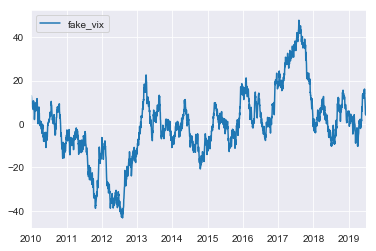

In [27]:
vix_path = vix.simulate_fake_vix(VIXPARAS, DATE_BEGIN, DATE_END)
df_op = df_op.join(vix_path, on='date')
vix_path.plot()

In [28]:
os.makedirs(clean_dir, exist_ok=True)
df_op.to_csv(clean_dir + 'processed.csv')

In [29]:
print('Number of samples stored: {}'.format(len(df_op)))

Number of samples stored: 3616964


##### Parameters record

In [30]:
shutil.copy('setup.py', f'{clean_dir}setup.py')

'C:\\Users\\Weiguan\\Dropbox\\Research\\DeepHedging\\Data\\OptionMetrics\\CleanData/setup.py'

In [31]:
with open(f'{clean_dir}/paras.txt', 'w+') as file:
    for n, x in [
    	('Random seed', RANDOM_SEED),
    	('Normalized price', NORM_FACTOR),
    	('First date', DATE_BEGIN),
    	('Last date', DATE_END),
        ('Number of samples in total', len(df_op))]:
        file.write(f'{n} = {x}\n')